---Sentiment analysis---
The script conducts sentiment analysis of news articles in the MIND dataset. It takes the PerSenT dataset for training, where articles are marked as postive, negative, or neutral, and applies this classification to the MIND articles. The classification is based on OpenAI's embeddings (text-embedding-ada-002). 


In [66]:
# imports
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt

In [67]:
news = pd.read_csv("data_embeddings/news_emb_test.csv") #document with user interactions
news.head()

,ID,Category,SubCategory,Content,Content_emb
0,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"[-0.0297758337110281, -0.014837449416518211, 0..."
1,N9721,health,nutrition,"50 Foods You Should Never Eat, According to He...","[0.012758416123688221, -0.009777242317795753, ..."
2,N39758,health,nutrition,25 Biggest Grocery Store Mistakes Making You G...,"[0.005077139008790255, -0.012759401462972164, ..."
3,N3574,autos,autosnews,Ford Bronco Test Mule Spotted Flexing Its Musc...,"[-0.03402266278862953, -0.02521878108382225, 0..."
4,N42474,news,newsbusiness,Trump's Trustbusters Bring Microsoft Lessons t...,"[-0.005269751418381929, -0.0184138435870409, 0..."


In [68]:
# Function to perform sentiment analysis using TextBlob
def analyze_sentiment(text):
    analysis = TextBlob(text)
    # Classify the polarity as positive, negative, or neutral
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis function to the specified column
news['Sentiment'] = news['Content'].apply(analyze_sentiment)

# Display the DataFrame with the new sentiment analysis column
news.head()


,ID,Category,SubCategory,Content,Content_emb,Sentiment
0,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"[-0.0297758337110281, -0.014837449416518211, 0...",Neutral
1,N9721,health,nutrition,"50 Foods You Should Never Eat, According to He...","[0.012758416123688221, -0.009777242317795753, ...",Negative
2,N39758,health,nutrition,25 Biggest Grocery Store Mistakes Making You G...,"[0.005077139008790255, -0.012759401462972164, ...",Negative
3,N3574,autos,autosnews,Ford Bronco Test Mule Spotted Flexing Its Musc...,"[-0.03402266278862953, -0.02521878108382225, 0...",Negative
4,N42474,news,newsbusiness,Trump's Trustbusters Bring Microsoft Lessons t...,"[-0.005269751418381929, -0.0184138435870409, 0...",Neutral


In [69]:
#news.to_csv("sentiment_test.csv")

Evaluation

In [70]:
news = news.drop(['Content_emb'], axis=1)
news.head()


,ID,Category,SubCategory,Content,Sentiment
0,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,Neutral
1,N9721,health,nutrition,"50 Foods You Should Never Eat, According to He...",Negative
2,N39758,health,nutrition,25 Biggest Grocery Store Mistakes Making You G...,Negative
3,N3574,autos,autosnews,Ford Bronco Test Mule Spotted Flexing Its Musc...,Negative
4,N42474,news,newsbusiness,Trump's Trustbusters Bring Microsoft Lessons t...,Neutral


In [71]:
behaviors = pd.read_csv("MIND/behaviors_testdataset.csv", sep=';', header=None)
behaviors.columns =['User', 'Time', 'ID', 'Impressions'] 
behaviors = behaviors.drop(['Time', 'Impressions'], axis=1)
behaviors.head()

,User,ID
0,U13000,N42782 N18445 N49749
1,U14000,N9721 N61358 N11360 N64593 N9900 N46688
2,U15000,N42474 N41013 N45970 N4015 N56461 N11161 N31633
3,U13740,N55189 N42782 N34694 N45794 N18445 N63302 N104...
4,U91836,N31739 N6072 N63045 N23979 N35656 N43353 N8129...


In [72]:

def generate_user_graphs(user_id, behaviors_df, news_df):
    # Get the list of articles read by the user
    user_articles = behaviors_df[behaviors_df['User'] == user_id]['ID'].str.split().explode().tolist()

    # Filter news_df based on user's articles
    user_news_df = news_df[news_df['ID'].isin(user_articles)]

    # Plot Category distribution
    category_counts = user_news_df['Category'].value_counts()
    plt.figure(figsize=(10, 5))
    category_counts.plot(kind='bar', color='skyblue')
    plt.title('Category Distribution for User {}'.format(user_id))
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.show()

    # Plot SubCategory distribution
    subcategory_counts = user_news_df['SubCategory'].value_counts()
    plt.figure(figsize=(10, 5))
    subcategory_counts.plot(kind='bar', color='lightcoral')
    plt.title('SubCategory Distribution for User {}'.format(user_id))
    plt.xlabel('SubCategory')
    plt.ylabel('Count')
    plt.show()

    # Plot Sentiment distribution
    sentiment_counts = user_news_df['Sentiment'].value_counts()
    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind='bar', color='lightgreen')
    plt.title('Sentiment Distribution for User {}'.format(user_id))
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()


In [73]:

def generate_recommendation_graphs(n, user_id, news_df):
    recommendation_df = pd.read_csv("content_recommendations/" + user_id + "_cont.csv")
    # Take the first n rows from the recommendation dataframe
    top_n_recommendations = recommendation_df.head(n)

    # Extract the IDs from the recommendation dataframe
    recommended_ids = top_n_recommendations['ID'].tolist()

    # Filter news_df based on recommended IDs
    recommended_news_df = news_df[news_df['ID'].isin(recommended_ids)]

    # Plot Category distribution
    category_counts = recommended_news_df['Category'].value_counts()
    plt.figure(figsize=(10, 5))
    category_counts.plot(kind='bar', color='skyblue')
    plt.title('Category Distribution for Top {} Recommendations'.format(n))
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.show()

    # Plot SubCategory distribution
    subcategory_counts = recommended_news_df['SubCategory'].value_counts()
    plt.figure(figsize=(10, 5))
    subcategory_counts.plot(kind='bar', color='lightcoral')
    plt.title('SubCategory Distribution for Top {} Recommendations'.format(n))
    plt.xlabel('SubCategory')
    plt.ylabel('Count')
    plt.show()

    # Plot Sentiment distribution
    sentiment_counts = recommended_news_df['Sentiment'].value_counts()
    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind='bar', color='lightgreen')
    plt.title('Sentiment Distribution for Top {} Recommendations'.format(n))
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()


In [109]:
#user = "U91836"
user = "U15000"

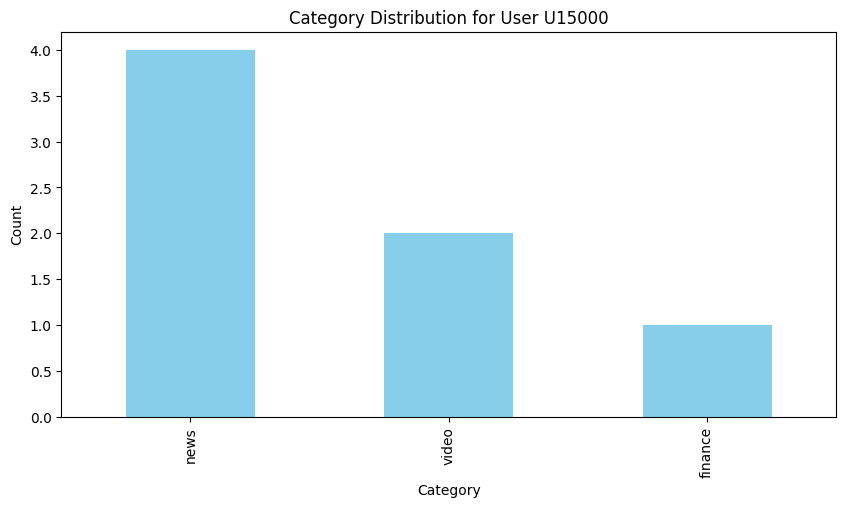

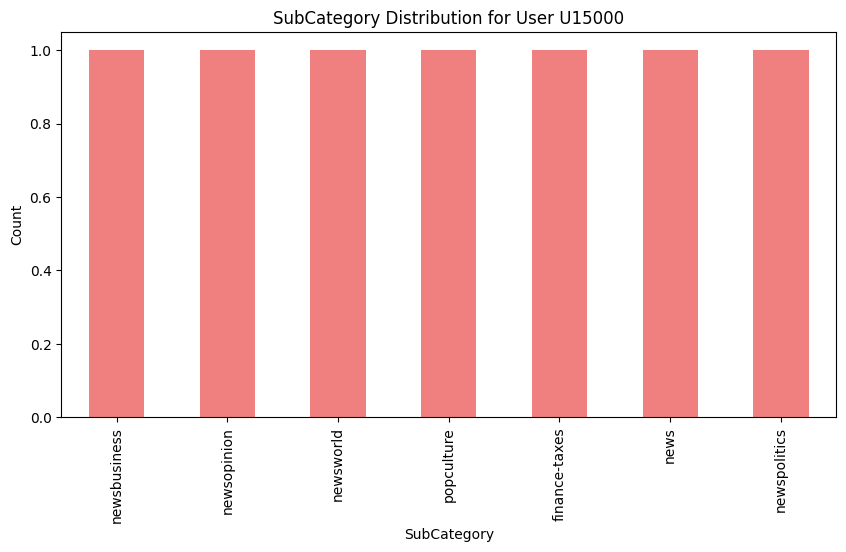

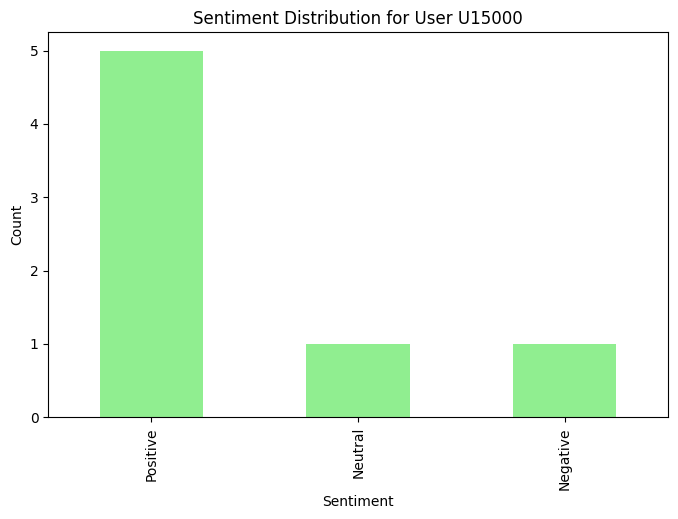

In [110]:
generate_user_graphs(user, behaviors, news)

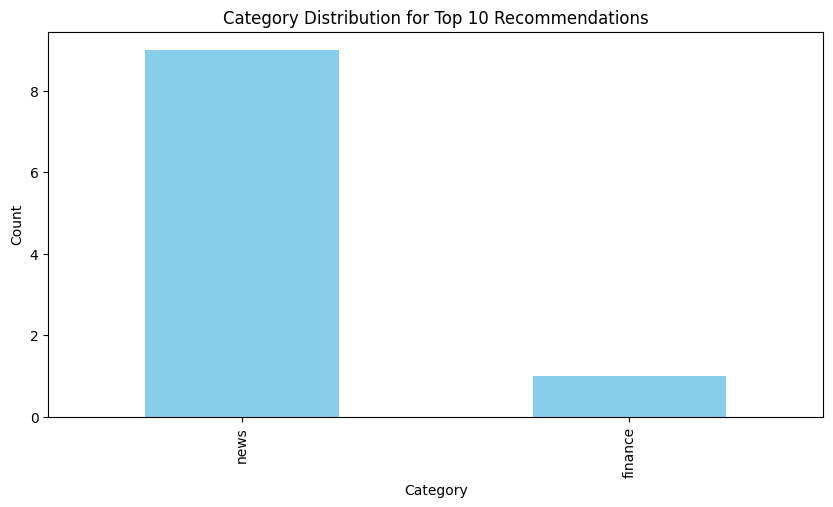

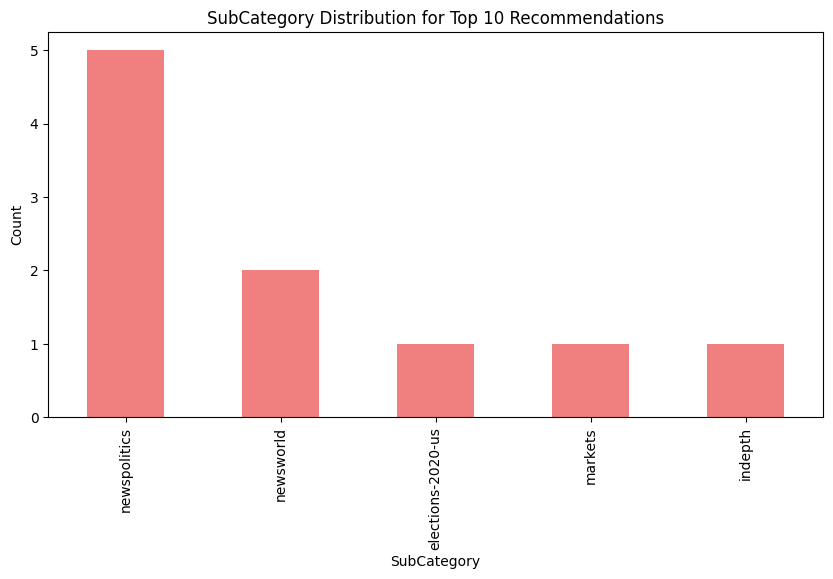

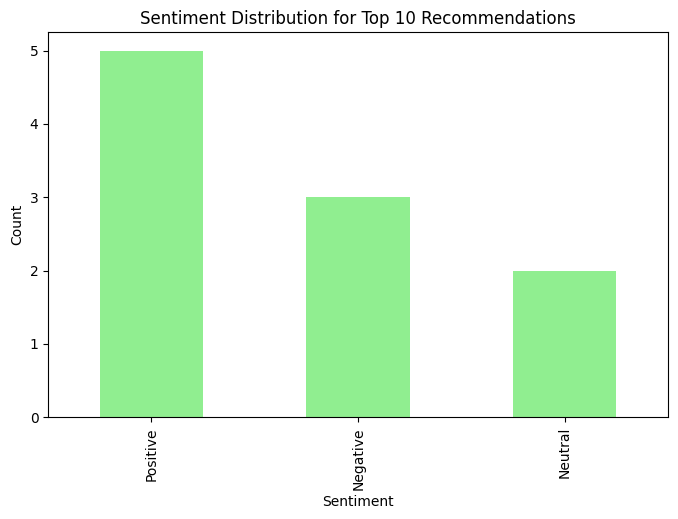

In [111]:
generate_recommendation_graphs(10, user, news)